Preprocessing data...
Loaded 3193 images and height arrays.
Extracting HOG features for the entire dataset...
Data split into training and test sets: 2554 training samples and 639 test samples.
Training fold 1...
Fold 1 - MSE: 0.0043, RMSE: 0.0658, MAE: 0.0501, R2: 0.7878
Training fold 2...
Fold 2 - MSE: 0.0041, RMSE: 0.0639, MAE: 0.0471, R2: 0.7922
Training fold 3...
Fold 3 - MSE: 0.0042, RMSE: 0.0645, MAE: 0.0481, R2: 0.8123
Training fold 4...
Fold 4 - MSE: 0.0044, RMSE: 0.0661, MAE: 0.0495, R2: 0.7894
Training fold 5...
Fold 5 - MSE: 0.0051, RMSE: 0.0717, MAE: 0.0505, R2: 0.7790
Mean cross-validation MSE: 0.0044
Fitting final model on all training data...
Test set MSE: 0.0034
Test set RMSE: 0.0580
Test set MAE: 0.0440
Test set R2: 0.8368


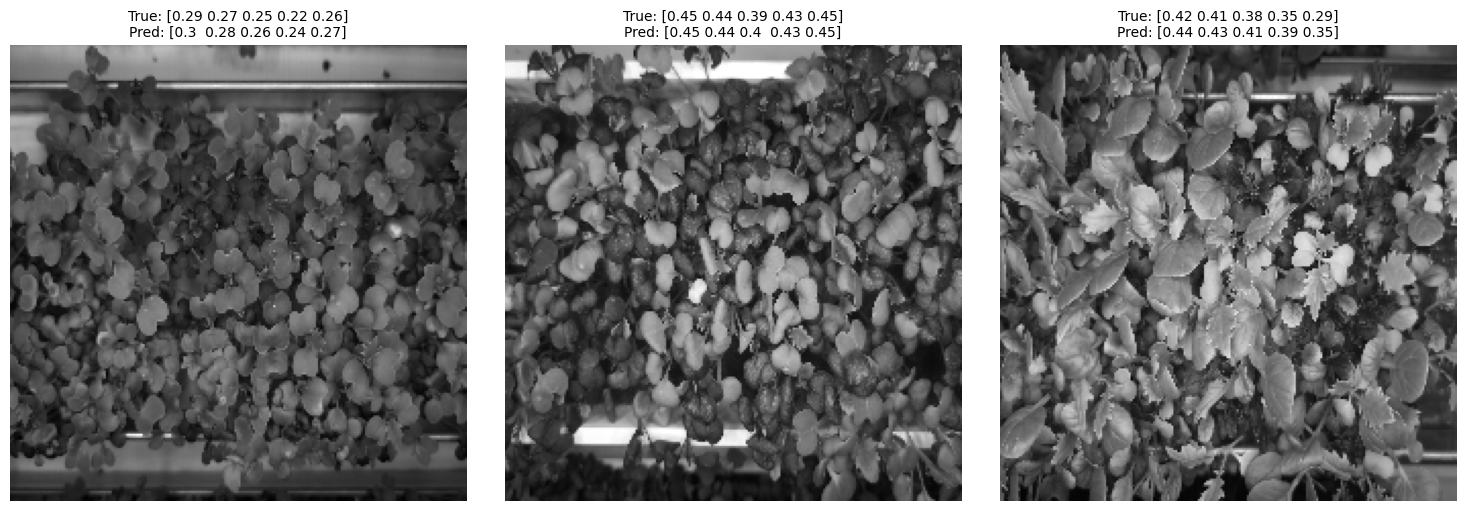

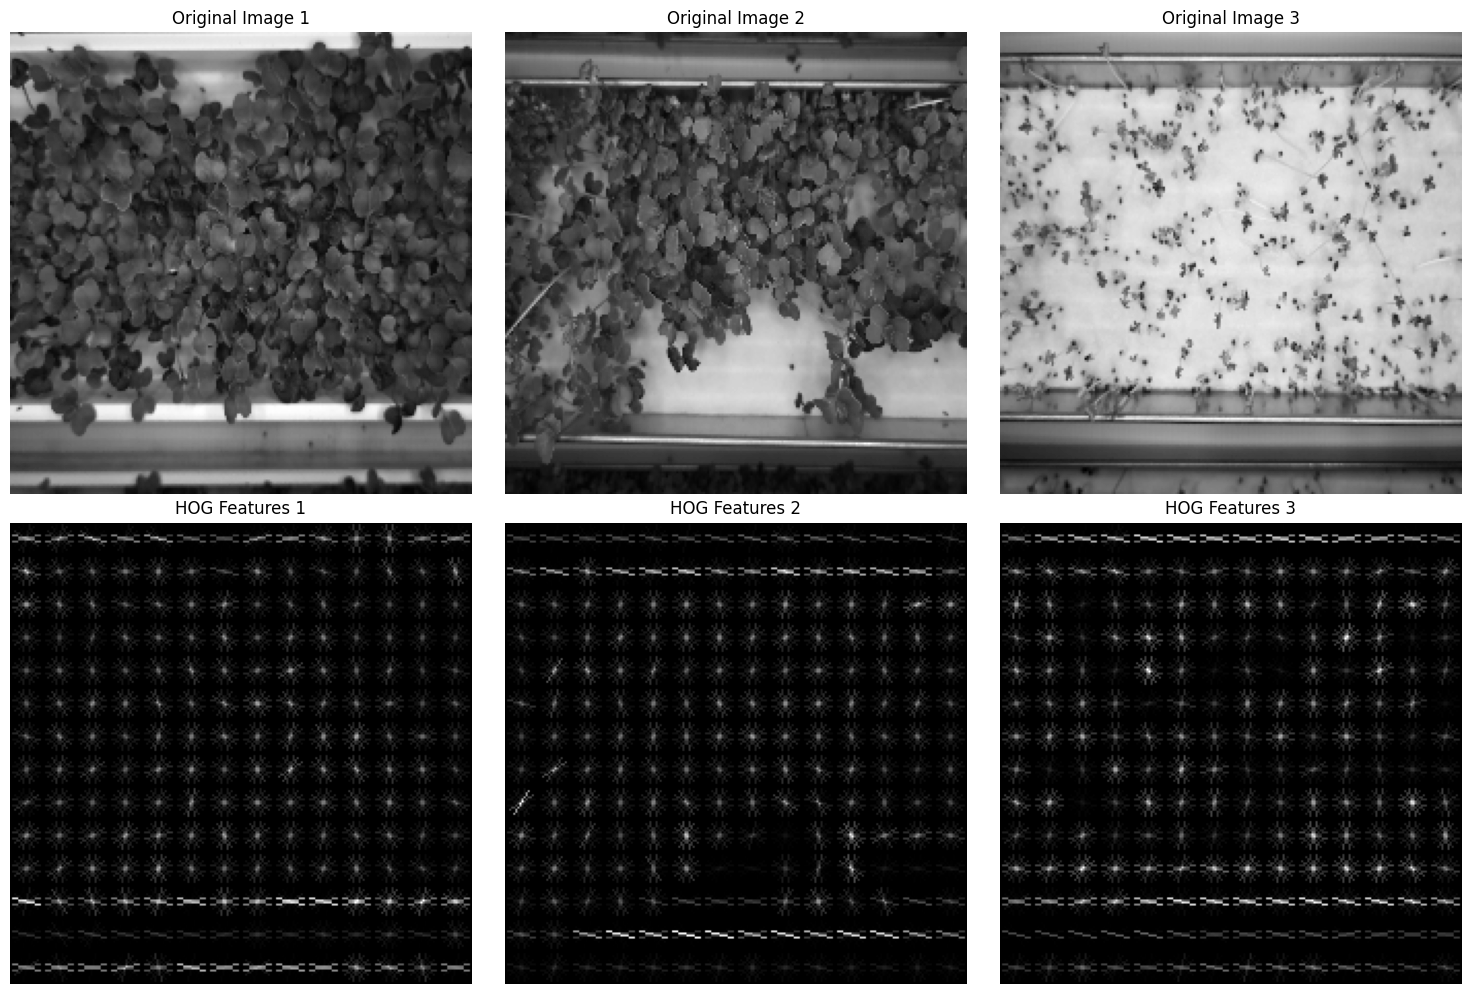

In [27]:
# training script for final top 5-split regression prediction model with 5-fold cv and saving of test results and various metrics

import os
import numpy as np
import cv2
import pandas as pd
import json
from skimage.feature import hog
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from skimage import exposure
from tqdm import tqdm
import concurrent.futures
import pickle
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Paths to the folders containing the images and height arrays
image_folder = 'bright_spicy_2024/CNN_top_images'
height_folder = 'bright_spicy_2024/CNN_height_arrays'
csv_path = 'CNN_input.csv'
model_save_path = 'RF_5split_hp_top_model_NO_TRIM.pkl'
results_save_path = 'RF_results/5split_top_RF_results_NO_TRIM.csv'
plot_save_path = 'RF_results/5split_top_RF_cv_plot_NO_TRIM.png'
test_results_path = 'RF_results/5split_top_RF_test_results_NO_TRIM.json'
metrics_save_path = 'RF_results/5split_top_RF_metrics_NO_TRIM.json'
test_set_save_path = 'RF_results/5split_top_RF_test_set_NO_TRIM.csv'

# Best hyperparameters
best_params = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

def calculate_means(height_array, num_parts=5):
    part_size = len(height_array) // num_parts
    means = [np.mean(height_array[i * part_size:(i + 1) * part_size]) for i in range(num_parts)]
    return means

def load_image_and_height(height_file, top_image_name, image_folder, height_folder, num_parts=5):
    height_path = os.path.join(height_folder, height_file + '.npy')
    img_path = os.path.join(image_folder, top_image_name)

    if not os.path.exists(img_path):
        print(f"Image file does not exist: {img_path}")
        return None, None

    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return None, None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Rotate the image 180 degrees
    img = cv2.rotate(img, cv2.ROTATE_180)

    height, width = img.shape[:2]
    start_x = (width - 3280) // 2
    start_y = (height - 2464) // 2
    img = img[start_y:start_y + 2464, start_x:start_x + 3280]  # Symmetric crop
    img = cv2.resize(img, (224, 224))

    height_array = np.load(height_path)
    if height_array.size == 0:
        print(f"Height array is empty: {height_path}")
        return None, None

    height_array = height_array / 2464.0

    mean_heights = calculate_means(height_array, num_parts)
    return img, mean_heights


def preprocess_data(height_files, top_images, image_folder, height_folder, num_parts=5):
    images, mean_heights = [], []  # Correct initialization
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(load_image_and_height, height_files, top_images, [image_folder]*len(height_files), [height_folder]*len(height_files), [num_parts]*len(height_files)))
    for img, mean_height in results:
        if img is not None and mean_height is not None:
            images.append(img)
            mean_heights.append(mean_height)
    print(f"Loaded {len(images)} images and height arrays.")
    return np.array(images), np.array(mean_heights)

def custom_preprocessing(img):
    img = np.array(img)
    for channel in range(img.shape[2]):
        img[..., channel] = exposure.rescale_intensity(img[..., channel], out_range=(0, 1))
        img[..., channel] = exposure.equalize_hist(img[..., channel])
        img[..., channel] = exposure.equalize_adapthist(img[..., channel], clip_limit=0.03)
    return img

csv_data = pd.read_csv(csv_path)
height_files = csv_data.iloc[:, 0].tolist()
top_images = csv_data.iloc[:, 1].tolist()

print("Preprocessing data...")
images, mean_heights = preprocess_data(height_files, top_images, image_folder, height_folder)
if len(images) == 0 or len(mean_heights) == 0:
    raise ValueError("No images or height arrays were loaded. Please check the data folder and files.")

images = images / 255.0

mean_heights = np.array(mean_heights).reshape(len(mean_heights), -1)

def extract_hog_features(image):
    gray_image = (image * 255).astype(np.uint8)
    gray_image = cv2.cvtColor(gray_image, cv2.COLOR_RGB2GRAY)
    fd, hog_image = hog(gray_image, orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=True)
    return fd, hog_image

print("Extracting HOG features for the entire dataset...")
hog_features = []
hog_images = []
for img in images:
    fd, hog_image = extract_hog_features(img)
    hog_features.append(fd)
    hog_images.append(hog_image)
hog_features = np.array(hog_features)

X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    hog_features, mean_heights, np.arange(len(hog_features)), test_size=0.2, random_state=42)

print(f"Data split into training and test sets: {len(X_train)} training samples and {len(X_test)} test samples.")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
cv_results = []
fold_metrics = []

for train_index, val_index in kf.split(X_train):
    print(f"Training fold {fold}...")
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    
    model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42
    )

    model.fit(X_train_cv, y_train_cv)
    y_pred_val = model.predict(X_val_cv)
    
    mse_val = mean_squared_error(y_val_cv, y_pred_val)
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_val_cv, y_pred_val)
    r2_val = r2_score(y_val_cv, y_pred_val)
    
    fold_results = {
        'fold': fold,
        'mse': mse_val,
        'rmse': rmse_val,
        'mae': mae_val,
        'r2': r2_val
    }
    
    cv_results.append(mse_val)
    fold_metrics.append(fold_results)
    
    print(f"Fold {fold} - MSE: {mse_val:.4f}, RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R2: {r2_val:.4f}")
    fold += 1

mean_cv_mse = np.mean(cv_results)
print(f"Mean cross-validation MSE: {mean_cv_mse:.4f}")

# Save cross-validation results
cv_results_dict = {
    'fold_mse': cv_results,
    'mean_cv_mse': mean_cv_mse
}
pd.DataFrame(cv_results_dict).to_csv(results_save_path, index=False)

# Save fold metrics
with open(results_save_path.replace('.csv', '_detailed.json'), 'w') as f:
    json.dump(fold_metrics, f)

final_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
print("Fitting final model on all training data...")
final_model.fit(X_train, y_train)

with open(model_save_path, 'wb') as f:
    pickle.dump(final_model, f)

y_pred_test = final_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f'Test set MSE: {mse_test:.4f}')
print(f'Test set RMSE: {rmse_test:.4f}')
print(f'Test set MAE: {mae_test:.4f}')
print(f'Test set R2: {r2_test:.4f}')

test_results_dict = {
    'y_test': y_test.tolist(),
    'y_pred_test': y_pred_test.tolist()
}
with open(test_results_path, 'w') as f:
    json.dump(test_results_dict, f)

metrics_dict = {
    'mse_test': mse_test,
    'rmse_test': rmse_test,
    'mae_test': mae_test,
    'r2_test': r2_test
}
with open(metrics_save_path, 'w') as f:
    json.dump(metrics_dict, f)

# Save test set information (image names and indices)
test_set_info = pd.DataFrame({
    'height_files': np.array(height_files)[test_indices],
    'top_images': np.array(top_images)[test_indices],
    'y_test': y_test.tolist(),
    'y_pred_test': y_pred_test.tolist()
})
test_set_info.to_csv(test_set_save_path, index=False)

def visualize_predictions(images, true_heights, predicted_heights, num_samples=3):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        img = images[idx]
        true_height = true_heights[idx]
        predicted_height = predicted_heights[idx]
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY), cmap='gray')
        plt.title(f"True: {np.round(true_height, 2)}\nPred: {np.round(predicted_height, 2)}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(images, mean_heights, final_model.predict(hog_features), num_samples=3)

def visualize_hog_features(images, hog_images, num_samples=3):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        img = images[idx]
        hog_img = hog_images[idx]
        
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY), cmap='gray')
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(hog_img, cmap='gray')
        plt.title(f"HOG Features {i+1}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

visualize_hog_features(images, hog_images, num_samples=3)

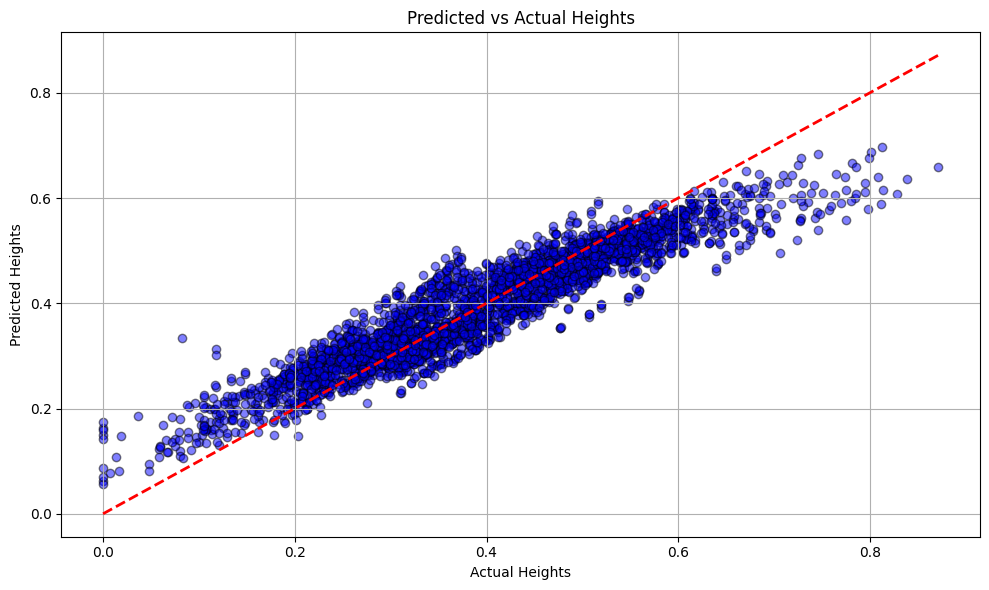

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the file containing test predictions and actual values
test_results_path = 'RF_results/5split_top_RF_test_results.json'

# Load the test results from the CSV file
test_results = pd.read_json(test_results_path)

# Extract actual values and predictions
y_test = np.array(test_results['y_test'].tolist())
y_pred_test = np.array(test_results['y_pred_test'].tolist())

# Flatten the arrays if they are nested
y_test_flat = y_test.flatten()
y_pred_test_flat = y_pred_test.flatten()

# Generate the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_flat, y_pred_test_flat, alpha=0.5, color='b', edgecolors='k')
plt.title('Predicted vs Actual Heights')
plt.xlabel('Actual Heights')
plt.ylabel('Predicted Heights')
plt.plot([y_test_flat.min(), y_test_flat.max()], [y_test_flat.min(), y_test_flat.max()], color='red', linestyle='--', linewidth=2)  # Diagonal line
plt.grid(True)
plt.tight_layout()

# Save the plot to the specified path
scatter_plot_save_path = 'RF_results/pred_vs_actual_scatter_plot.png'
plt.savefig(scatter_plot_save_path)

# Show the plot
plt.show()


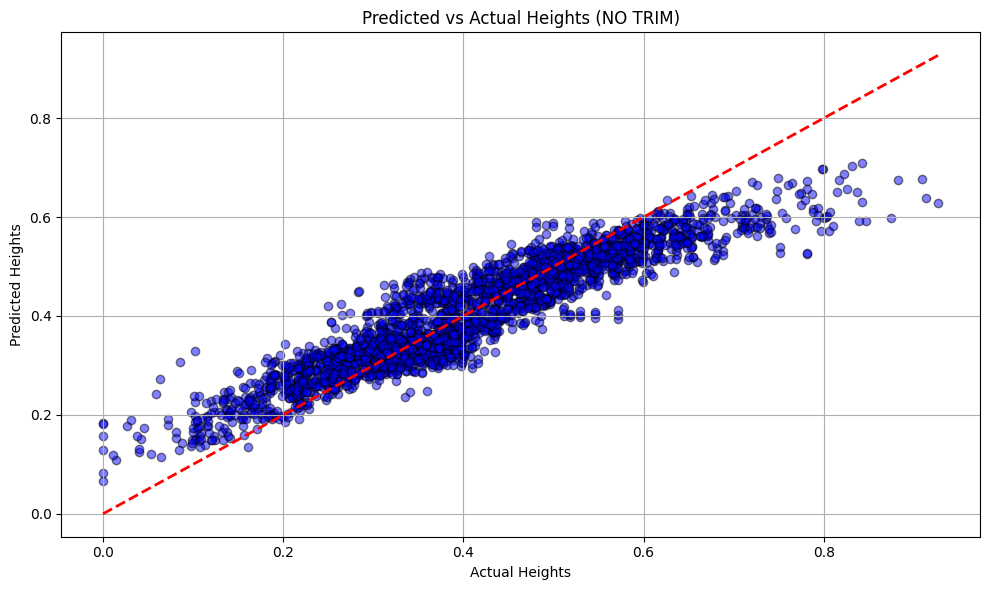

In [28]:
# FOR THE NO TRIM:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Path to the file containing test predictions and actual values
test_results_path = 'RF_results/5split_top_RF_test_results_NO_TRIM.json'

# Load the test results from the JSON file
test_results = pd.read_json(test_results_path)

# Extract actual values and predictions
y_test = np.array(test_results['y_test'].tolist())
y_pred_test = np.array(test_results['y_pred_test'].tolist())

# Flatten the arrays if they are nested
y_test_flat = y_test.flatten()
y_pred_test_flat = y_pred_test.flatten()

# Generate the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_flat, y_pred_test_flat, alpha=0.5, color='b', edgecolors='k')
plt.title('Predicted vs Actual Heights (NO TRIM)')
plt.xlabel('Actual Heights')
plt.ylabel('Predicted Heights')
plt.plot([y_test_flat.min(), y_test_flat.max()], [y_test_flat.min(), y_test_flat.max()], color='red', linestyle='--', linewidth=2)  # Diagonal line
plt.grid(True)
plt.tight_layout()

# Save the plot to the specified path
scatter_plot_save_path = 'RF_results/5split_top_RF_pred_vs_actual_scatter_plot_NO_TRIM.png'
plt.savefig(scatter_plot_save_path)

# Show the plot
plt.show()
